In [4]:
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import preprocessing
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import pandas as pd
import phate
import math
import random
import gc
import scprep
from datetime import datetime, time
from matplotlib.animation import ImageMagickWriter
import matplotlib.animation as animation
import zipfile
from urllib.request import urlopen
import scipy.stats as st
from scipy.stats import norm
from scipy.stats import gaussian_kde
from scipy.stats import kde
from scipy.stats import binned_statistic
from scipy.stats import f_oneway
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams['pdf.fonttype'] = 42
print(sns.__version__)
from anndata import AnnData
import scanpy as sc
from delve import *
import anndata as ad
from sklearn.preprocessing import MinMaxScaler
from kh import sketch
from sklearn.cluster import KMeans
import umap
print(sc.__version__)
today = datetime.now().strftime("%m%d%Y-%H%M")

0.11.2
1.9.1


In [5]:
#Read back in the subsampled adata file
adata_save_path = r'Z:\Garrett\4i_data\112723_RPE_31day_Etop\experiment\cell_data\standard_trimmed_noPSTAT5_adata_sub.h5ad'
standard_trimmed_noPSTAT5_adata_sub = anndata.read_h5ad(adata_save_path)

c:\Users\gases\.conda\envs\python_3_7\lib\site-packages\anndata\_core\anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [6]:
# Adjusted list comprehension to exclude var_names containing "total"
columns_to_keep = [name for name in standard_trimmed_noPSTAT5_adata_sub.var_names if "total_nuc_protein" not in name]

# Selecting the data with only the columns to keep
standard_trimmed_noPSTAT5_noTotal_adata_sub = standard_trimmed_noPSTAT5_adata_sub[:, columns_to_keep]


In [7]:
def laplacian_score_fs(adata = None,
                    k: int  = None,
                    n_jobs: int  = -1):

    X, feature_names, obs_names = parse_input(adata)
    W = construct_affinity(X = X, k = k, n_jobs = n_jobs)
    scores = laplacian_score(X = X, W = W)
    predicted_features = pd.DataFrame(scores, index = feature_names, columns = ['laplacian_score'])
    predicted_features = predicted_features.sort_values(by = 'laplacian_score', ascending = True)

    return predicted_features 

In [8]:
#l_score_fullest = laplacian_score_fs(adata_fullest_sub, k = 200)
l_score_standard = laplacian_score_fs(standard_trimmed_noPSTAT5_noTotal_adata_sub, k = 100)
#l_score_normalized = laplacian_score_fs(normalized_trimmed_noPSTAT5_adata_sub, k = 200)

In [9]:
len(l_score_standard)

66

In [10]:
l_score_standard.index[:46]

Index(['R5_p38_nuc_mean', 'R0_pRb_nuc_mean', 'R6_pSTAT3_ring_mean',
       'R2_IL6_ring_mean', 'R0_pRb_ratio', 'R6_p65_ring_mean',
       'R6_pSTAT3_nuc_mean', 'R5_p38_ring_mean', 'R6_p65_nuc_mean',
       'R4_IL8_ring_mean', 'R0_Rb_ratio', 'R1_p21_nuc_mean', 'R2_IL6_nuc_mean',
       'R7_GATA4_nuc_mean', 'R1_p21_ratio', 'R0_Rb_nuc_mean',
       'R7_GATA4_ring_mean', 'nuc_area', 'R5_p38_ratio', 'R7_pp38_nuc_mean',
       'R2_pp65_ring_mean', 'R1_p16_nuc_mean', 'R3_p53_ring_mean',
       'R2_pp65_nuc_mean', 'R3_PLAUR_ring_mean', 'R3_PLAUR_nuc_mean',
       'R1_Jak2_nuc_mean', 'R7_pp38_ring_mean', 'R5_STAT5_ratio',
       'R5_STAT5_nuc_mean', 'R6_p65_ratio', 'R7_pp38_ratio',
       'R1_p21_ring_mean', 'R1_p16_ring_mean', 'R4_PARP1_nuc_mean',
       'R6_pSTAT3_ratio', 'minor_axis_length', 'R5_STAT5_ring_mean',
       'R3_p53_nuc_mean', 'R1_Jak2_ratio', 'R2_IL6_ratio', 'R1_Jak2_ring_mean',
       'R2_pp65_ratio', 'R4_PARP1_ratio', 'R7_GATA4_ratio',
       'major_axis_length'],
      dtype=

Code below taking inputs from Slingshot processing (Done in R) and any provided Clustering strategy.
Phate must be run and the PHATE coordinates saved using methods from the PHATE plotting notebook.
Produces a graph that plots specified clusters and overlays the Lineage information provided by Slingshot.

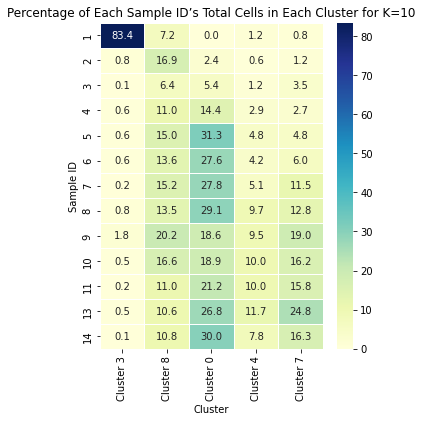

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans
from PIL import Image

# Step 1: Retrieve the PHATE embeddings from the AnnData object
embedding = standard_trimmed_noPSTAT5_adata_sub.obsm['X_phate']

# Gather all unique sample IDs to ensure they are represented in the final table
all_sample_ids = standard_trimmed_noPSTAT5_adata_sub.obs['sample_ID'].unique()

# Define a list of K values to loop through
k_values = [10]

# Specify the order of the clusters you want to plot
clusters_to_plot = [3, 8, 0, 4, 7]

# Specify the order of the columns to be plotted on the table
columns_to_plot = ['Cluster 3', 'Cluster 8', 'Cluster 0', 'Cluster 4', 'Cluster 7']

# Load CSV data
csv_path = r'C:\Users\gases\Desktop\slingshot_trajectories.csv'
lineage_data = pd.read_csv(csv_path)  # Changed variable name to lineage_data

# Identify unique lineages and assign a color to each
unique_lineages = lineage_data['Lineage'].unique()
lineage_color_map = plt.get_cmap('tab10', len(unique_lineages))
lineage_colors = lineage_color_map(np.linspace(0, 1, len(unique_lineages)))
lineage_color_dict = dict(zip(unique_lineages, lineage_colors))

for k in k_values:
    # Run K-means clustering for the current value of K using the precomputed PHATE embeddings
    kmeans = KMeans(n_clusters=k, random_state=0).fit(embedding)
    
    # Assign the cluster labels back to the AnnData object
    cluster_label = f'kmeans_clusters_k{k}'
    standard_trimmed_noPSTAT5_adata_sub.obs[cluster_label] = kmeans.labels_.astype(str)
    
    # Plotting the clusters
    views = [(30, 30), (30, 120), (30, 210), (30, 300)]
    
    for i, (elev, azim) in enumerate(views, start=1):
        # Create a 3D subplot for points with white background
        fig_points = plt.figure(figsize=(20, 16))
        ax_points = fig_points.add_subplot(1, 1, 1, projection='3d', facecolor='white')
        cluster_handles = []
        for cluster in clusters_to_plot:
            mask = kmeans.labels_ == cluster
            scatter = ax_points.scatter(embedding[mask, 0], embedding[mask, 1], embedding[mask, 2], label=f'Cluster {cluster}', s=50, zorder=1)
            cluster_handles.append(scatter)
        
        ax_points.scatter(embedding[:, 0], embedding[:, 1], embedding[:, 2], c='gray', alpha=0.3, s=5, zorder=0)
        ax_points.view_init(elev=elev, azim=azim)
        ax_points.set_xlabel('PHATE 1')
        ax_points.set_ylabel('PHATE 2')
        ax_points.set_zlabel('PHATE 3')
        ax_points.set_title(f'View {i} - Elev {elev}, Azim {azim}')
        ax_points.set_facecolor('white')  # Set the background color to white

        # Capture the axis limits
        xlim = ax_points.get_xlim()
        ylim = ax_points.get_ylim()
        zlim = ax_points.get_zlim()
        
        fig_points.savefig(f'points_view_{i}.png', transparent=True)
        plt.close(fig_points)
        
        # Create a 3D subplot for lines with the same axis limits and transparent background
        fig_lines = plt.figure(figsize=(20, 16))
        ax_lines = fig_lines.add_subplot(1, 1, 1, projection='3d')
        fig_lines.patch.set_alpha(0)  # Set the figure background to be transparent
        ax_lines.patch.set_alpha(0)  # Set the axes background to be transparent
        ax_lines.axis('off')  # Remove the axis
        lineage_handles = []
        for lineage, lineage_color in lineage_color_dict.items():
            lineage_subset = lineage_data[lineage_data['Lineage'] == lineage].sort_values('Index')
            # Apply cutoff for Lineage 2
            if (lineage == 2) and ('Index' in lineage_subset.columns):
                lineage_subset = lineage_subset[lineage_subset['Index'] <= 70]
            line, = ax_lines.plot(lineage_subset['PHATE_1'], lineage_subset['PHATE_2'], lineage_subset['PHATE_3'], 
                                  color=lineage_color, label=f'Lineage {lineage}', linewidth=2, zorder=2)
            lineage_handles.append(line)
        
        ax_lines.view_init(elev=elev, azim=azim)
        ax_lines.set_xlim(xlim)
        ax_lines.set_ylim(ylim)
        ax_lines.set_zlim(zlim)
        # Remove axis labels and titles
        ax_lines.set_xlabel('')
        ax_lines.set_ylabel('')
        ax_lines.set_zlabel('')
        ax_lines.set_title('')
        fig_lines.savefig(f'lines_view_{i}.png', transparent=True)
        plt.close(fig_lines)
        
        # Combine images
        points_image = Image.open(f'points_view_{i}.png')
        lines_image = Image.open(f'lines_view_{i}.png')
        combined_image = Image.alpha_composite(points_image.convert('RGBA'), lines_image.convert('RGBA'))
        combined_image.save(f'combined_view_{i}.png')
        
        # Save the legend as a separate image
        fig_legend = plt.figure(figsize=(10, 5))
        ax_legend = fig_legend.add_subplot(111)
        ax_legend.axis('off')  # Hide the axes for the legend
        legend_handles = cluster_handles + lineage_handles
        legend_labels = [handle.get_label() for handle in legend_handles]
        legend = ax_legend.legend(handles=legend_handles, labels=legend_labels, loc='center', frameon=False)
        fig_legend.savefig(f'legend_view_{i}.png', transparent=True, bbox_inches='tight', pad_inches=0)
        plt.close(fig_legend)
    
    # Creating the table
    cluster_sample_table = pd.DataFrame(0, index=all_sample_ids, columns=[f'Cluster {i}' for i in range(k)])
    for i in range(k):
        cluster_counts = standard_trimmed_noPSTAT5_adata_sub.obs[standard_trimmed_noPSTAT5_adata_sub.obs[cluster_label] == str(i)].groupby('sample_ID').size()
        cluster_sample_table.loc[cluster_counts.index, f'Cluster {i}'] = cluster_counts

    # Calculate percentages row-wise
    cluster_sample_table_percentage = cluster_sample_table.div(cluster_sample_table.sum(axis=1), axis=0) * 100

    # Filter the table to include only the specified columns
    cluster_sample_table_filtered = cluster_sample_table_percentage[columns_to_plot]

    # Plotting the table as a heatmap
    plt.figure(figsize=(5, 6))
    sns.heatmap(cluster_sample_table_filtered, annot=True, cmap="YlGnBu", fmt=".1f", linewidths=.5)
    plt.title(f'Percentage of Each Sample ID’s Total Cells in Each Cluster for K={k}')
    plt.xlabel('Cluster')
    plt.ylabel('Sample ID')
    plt.show()
